## Categorização de Produtos - Classificação ML

Uma plataforma de infoprodutos estava com dificuldades de separar os produtos bons e os ruins de sua base de dados. De acordo com a regra de negócio da empresa, produtos com altas taxas de estorno, chargeback e alto volume de reclamações são considerados produtos ruins.

A classificação de produtos será criada para ajudar no monitoramento dos produtos e facilitar o acompanhamento mensal dos produtos com base nos seus indicadores. Assim, podendo definir metas para melhorar os produtos ativos e até utilizar para diferentes análises e tomadas de decisões. 

Portanto, o objetivo do projeto é categorizar de A a E, de forma hierárquica, os produtos de uma amostra com base no sua taxa de estorno, taxa de chargeback e o número de reclamações. Produtos da classe A apresentam os menores indicadores e a classe E os maiores indicadores.

Para isso, iremos avaliar uma amostra desses produtos e classificar por meio de um modelo KNN e um modelo de Árvore de Decisão para definir o melhor algoritmo de classificação.

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Balanceamento
from imblearn.over_sampling import SMOTE # pip install imbalanced-learn

# Nomalizacao
from sklearn.preprocessing import StandardScaler

# Divisao de treino e teste
from sklearn.model_selection import train_test_split

# algoritmo knn
from sklearn.neighbors import KNeighborsClassifier

# algoritmo arvore de decisao
from sklearn.tree import DecisionTreeClassifier

# avaliacao do modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


### 1. Importação dos Dados

In [377]:
indicadores_produtos = pd.read_csv("indicadores_produtos.csv", sep=';')
indicadores_produtos.head()

,produto_id,classificacao,tx_estorno,reclamacoes,tx_chargeback
0,123,A,0.01,0,0.02
1,63,A,0.08,5,0.05
2,130,A,0.16,4,0.07
3,111,A,0.17,6,0.09
4,117,A,0.26,8,0.05


In [378]:
indicadores_produtos.dtypes

produto_id         int64
classificacao     object
tx_estorno       float64
reclamacoes        int64
tx_chargeback    float64
dtype: object

### 2. Análise Exploratória dos Dados (AED)

In [379]:
indicadores_produtos.iloc[:,1:].describe()

,tx_estorno,reclamacoes,tx_chargeback
count,130.000000,130.000000,130.000000
mean,3.891077,32.892308,1.077000
std,2.173819,15.878046,0.851332
min,0.010000,0.000000,0.010000
25%,2.187500,21.250000,0.310000
50%,3.680000,32.000000,0.845000
75%,5.795000,44.750000,1.700000
max,7.960000,75.000000,2.970000


A amostra apresenta um total de 130 produtos.

A taxa de estorno dos produtos selecionados teve uma média de 3.89% e um desvio padrão de 2.17. A taxa mais alta é de 7.96% e a mais baixa é de 0.01%.

O número médio de reclamações é 33 com um desvio padrão de 15.9. O produto com mais reclamações teve 75 notificações, enquanto o mais baixo foi de 0 reclamações.

A taxa de chargeback dos produtos selecionados teve uma média de 1.08% e um desvio padrão de 0.85. A taxa mais alta é de 2.97% e a mais baixa é de 0.01%.

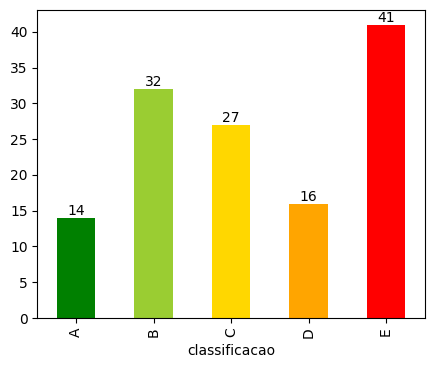

In [380]:
# Lista de cores para cada produto
cores = ['green','yellowgreen','gold', 'orange', 'red']

# Ordenando os valores da contagem por classificação
ordem_classificacao = ['A', 'B', 'C', 'D', 'E']  # Defina a ordem desejada
contagem_classificacoes = indicadores_produtos['classificacao'].value_counts().reindex(ordem_classificacao)

# Criando o gráfico de barras
plt.figure(figsize=(5, 4))
barras = contagem_classificacoes.plot.bar(color=cores)

# Adicionando rótulos em cima de cada barra
for barra in barras.patches:
    y = barra.get_height()
    x = barra.get_x() + barra.get_width() / 2
    plt.text(x, y, f'{y}', ha='center', va='bottom')

# Mostrando o gráfico
plt.show()

Nota-se que a maior parcela de produtos (31.5%) está na classificação E e a menor (10.8%) na classe A. Isso mostra que a amostra selecionada tem uma baixa qualidade dos produtos, já que, teoricamente, a classe A representa os produtos bons e E representa os produtos ruins.

In [381]:
# Percent de cada categoria
indicadores_produtos['classificacao'].value_counts()/len(indicadores_produtos)*100

classificacao
E    31.538462
B    24.615385
C    20.769231
D    12.307692
A    10.769231
Name: count, dtype: float64

In [382]:
indicadores_produtos.groupby(['classificacao'])['reclamacoes'].sum()

classificacao
A     149
B     807
C     844
D     630
E    1846
Name: reclamacoes, dtype: int64

Vemos que a classe com maior número de reclamações é a E (43.2%) e a menor é a classe A (3.5%). Porém, a classe D apresenta menos reclamações que as classes B e C. Podendo interpretar, de forma superficial, que a variável de reclamações deve apresentar um baixo peso sobre a mudança de classificação.

In [383]:
indicadores_produtos.iloc[:,1:].groupby(['classificacao']).mean()

,tx_estorno,reclamacoes,tx_chargeback
classificacao,,,
A,0.490714,10.642857,0.121429
B,2.012188,25.218750,0.356875
C,3.468889,31.259259,0.697037
D,4.591875,39.375000,1.599375
E,6.523171,45.024390,2.011707


Analisando o quadro das médias das variáveis por classe, vemos que quanto maior os valores, mais baixa é a classificação. Isso mostra que as classes pré definidas estão de acordo com o esperado.

/var/folders/3g/0w8v87l14fvbrs246qq9l0qc0000gn/T/ipykernel_37818/3255373316.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="classificacao", y=variaveis[i], data=indicadores_produtos, palette=cores_por_classificacao)
/var/folders/3g/0w8v87l14fvbrs246qq9l0qc0000gn/T/ipykernel_37818/3255373316.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="classificacao", y=variaveis[i], data=indicadores_produtos, palette=cores_por_classificacao)
/var/folders/3g/0w8v87l14fvbrs246qq9l0qc0000gn/T/ipykernel_37818/3255373316.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

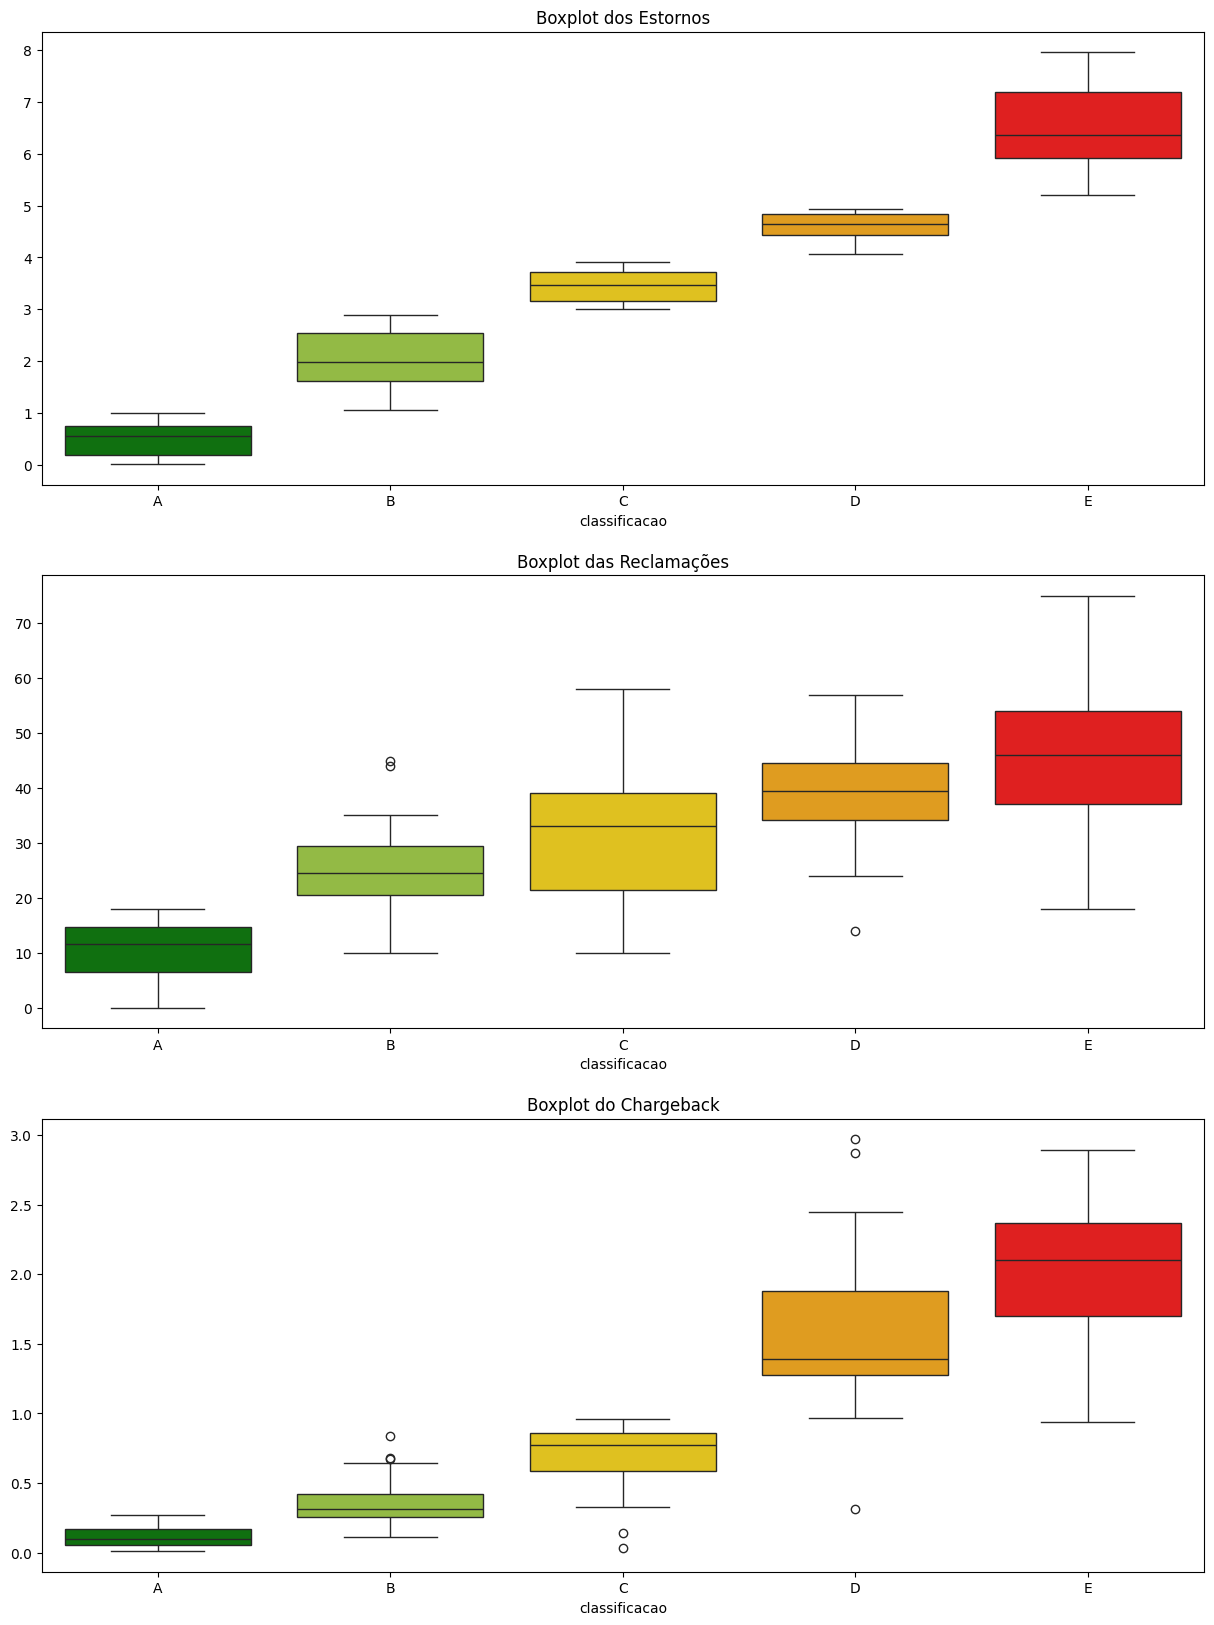

In [384]:
# Configurações dos gráficos
plt.figure(figsize=(15, 20))
variaveis = ["tx_estorno", "reclamacoes", "tx_chargeback"]
titulos = ["Boxplot dos Estornos", "Boxplot das Reclamações", "Boxplot do Chargeback"]

# Definindo um dicionário de cores para cada classificação
cores_por_classificacao = {"A": "green", "B": "yellowgreen", "C": "gold", "D": "orange", "E": "red"}

# Criando os boxplots em um loop
for i in range(3):
    plt.subplot(3, 1, i + 1)
    sns.boxplot(x="classificacao", y=variaveis[i], data=indicadores_produtos, palette=cores_por_classificacao)
    plt.ylabel("")  # Remove o rótulo do eixo y
    plt.title(titulos[i])

# Mostrando o gráfico
plt.show()

De acordo com o boxplot, vemos que os maiores valores são do grupo E e os menores valores do grupo A. Além disso, a ordem crescente dos gráficos também mostra que existe uma hierarquia entre as classes. Sendo a classe A superior a classe E, como anunciado anteriormente.

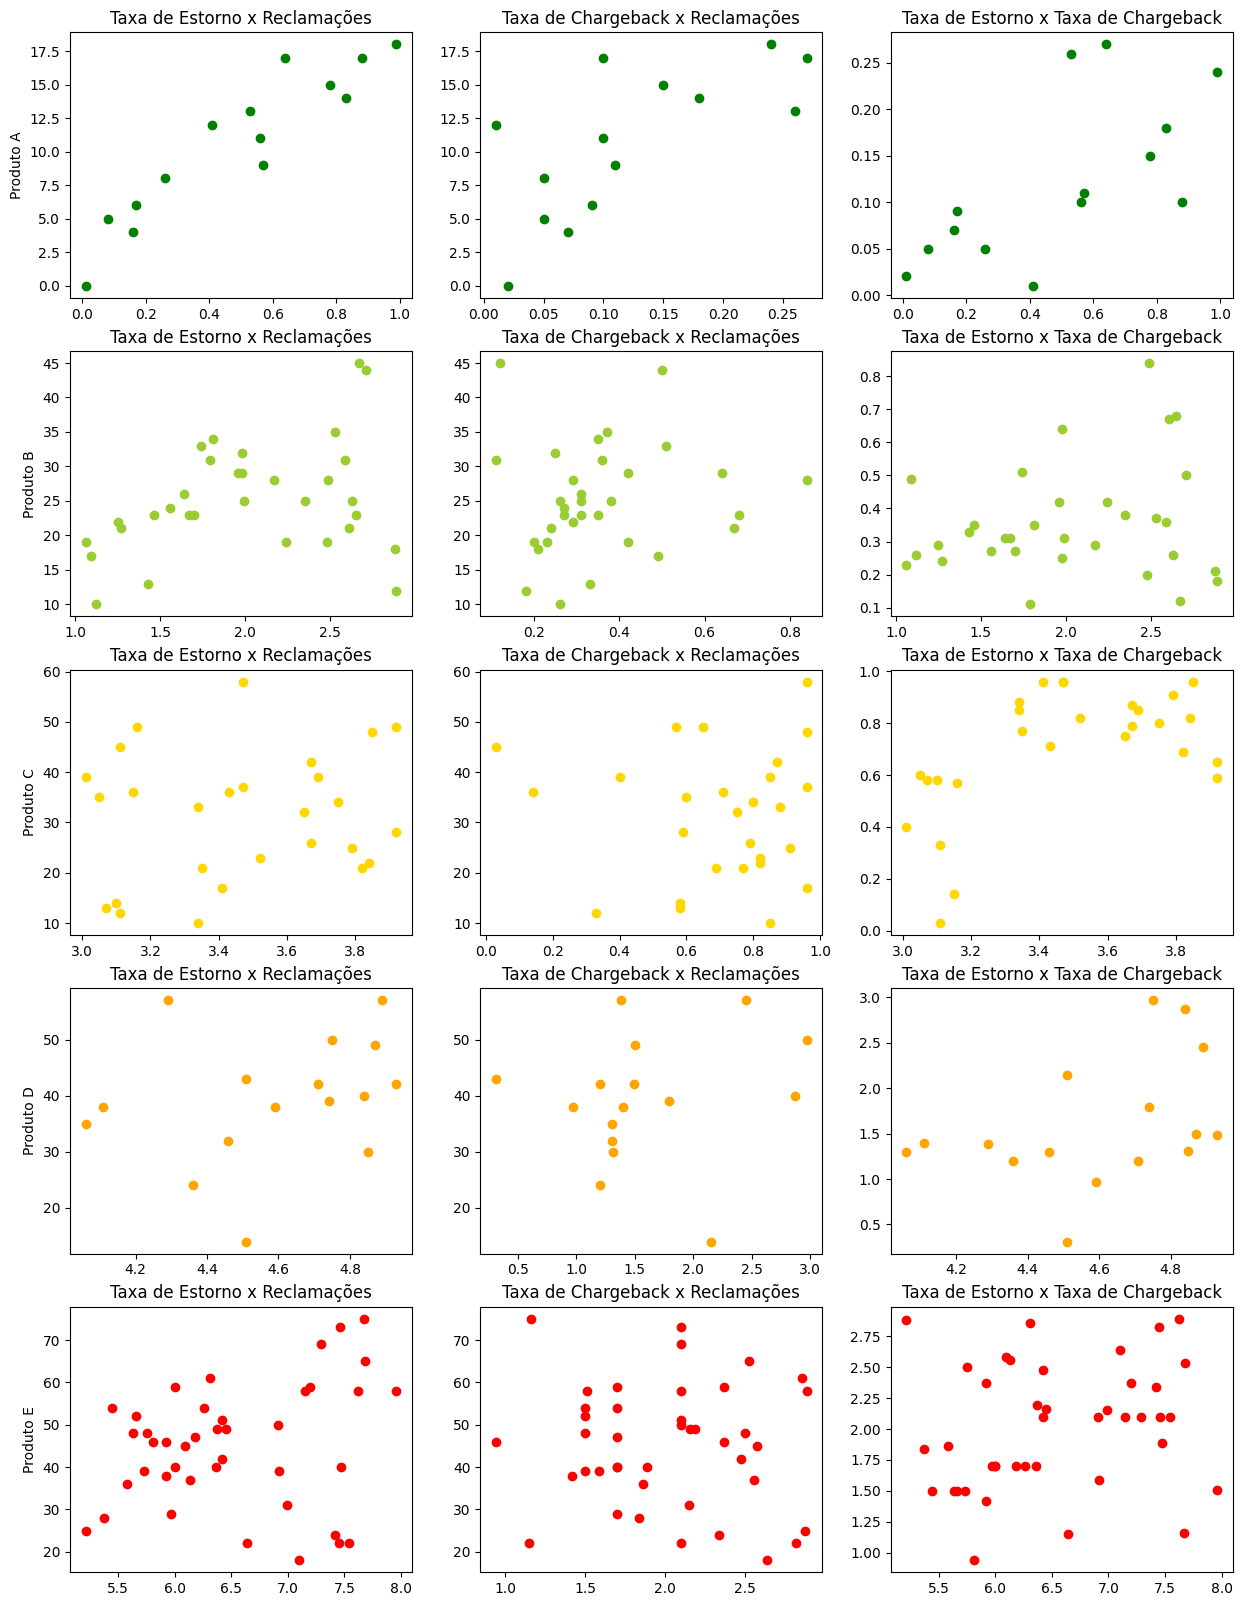

In [385]:
# Definir grupos
produto_A = indicadores_produtos.query('classificacao == "A"')
produto_B = indicadores_produtos.query('classificacao == "B"')
produto_C = indicadores_produtos.query('classificacao == "C"')
produto_D = indicadores_produtos.query('classificacao == "D"')
produto_E = indicadores_produtos.query('classificacao == "E"')

# Lista de produtos e seus nomes
produtos = [produto_A, produto_B, produto_C, produto_D, produto_E]
nomes_produtos = ["Produto A", "Produto B", "Produto C", "Produto D", "Produto E"]

# Títulos para os gráficos
titulos = [
    "Taxa de Estorno x Reclamações",
    "Taxa de Chargeback x Reclamações",
    "Taxa de Estorno x Taxa de Chargeback"
]

plt.figure(figsize=(15, 20))

# Contador para controlar o índice do subplot
contador = 1

# Loop pelos produtos, seus nomes e cores
for produto, nome, cor in zip(produtos, nomes_produtos, cores):
    # Loop pelos títulos
    for i, titulo in enumerate(titulos):
        plt.subplot(5, 3, contador)
        if titulo == "Taxa de Estorno x Reclamações":
            plt.scatter(produto['tx_estorno'], produto['reclamacoes'], color=cor)
        elif titulo == "Taxa de Chargeback x Reclamações":
            plt.scatter(produto['tx_chargeback'], produto['reclamacoes'], color=cor)
        elif titulo == "Taxa de Estorno x Taxa de Chargeback":
            plt.scatter(produto['tx_estorno'], produto['tx_chargeback'], color=cor)

        plt.title(titulo)

        # Adicionando o nome do produto à esquerda para a primeira coluna
        if i == 0:
            plt.ylabel(nome)

        contador += 1

plt.show()

O gráfico de dispersão apresenta a relação das variáveis independentes dentro de cada grupo de classe. Análisando de forma separada, não é possível encontrar um padrão entre os dados. Apenas no produto A é possível ver uma relação positiva entre as variáveis.

In [386]:
indicadores_produtos['classificacao'] = indicadores_produtos['classificacao'].map( {'A':5, 'B':4, 'C':3, 'D':2, 'E':1} )

Para verificar a correlação das variáveis com a classificação, é necessário passar a variável categórica 'classificacao' para uma variável númerica, em que A=5, B=4, C=3, D=2, E=1, já que indica uma hierarquia.

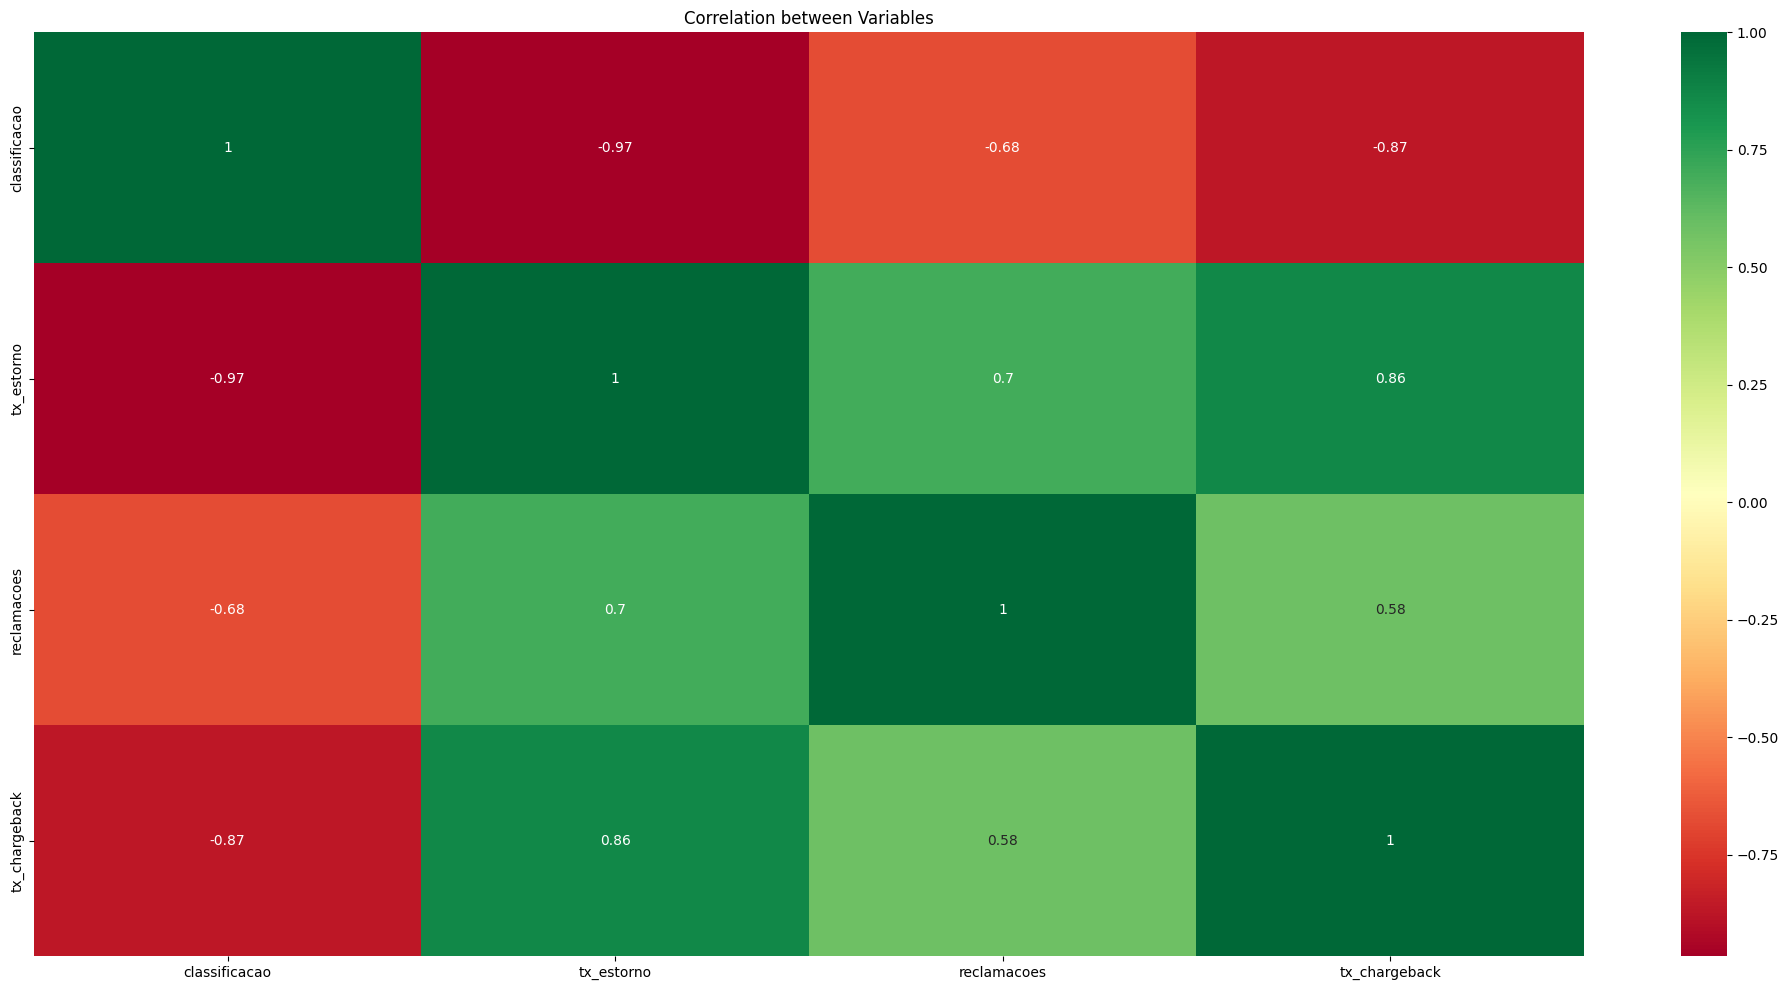

In [387]:
plt.figure(figsize=(25, 12))
sns.heatmap(indicadores_produtos.iloc[:,1:].corr(), cmap='RdYlGn', annot = True)
plt.title("Correlation between Variables")
plt.show()

De acordo com o heatmap, vemos que todas as variáveis apresentam uma relação negativa com a classificação dos produtos. As taxas de estorno e chargeback apresentaram uma correlação negativa de 0.97 e 0.87, respectivamente. Como foi falado anteriormente, as reclamações apresentaram a menor correlação entre a variável de classificação.

Além disso, todas as variáveis independentes apresentaram relação positivas entre si, ou seja, produtos com alto nível de chargeback também apresentam alto estorno e reclamações.

### 3. Balanceamento

A base foi balanceada usando o método Oversampling por conta do baixo número de observações da amostra. Se o seu conjunto de dados é pequeno, o undersampling pode levar à perda de informações valiosas. Nesses casos, o oversampling é preferível para aumentar o tamanho da classe minoritária.

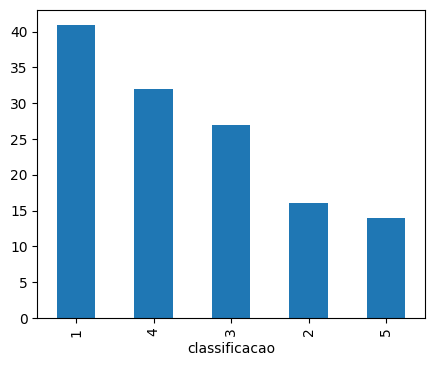

In [388]:
plt.figure(figsize=(5, 4))
indicadores_produtos['classificacao'].value_counts().plot.bar()
plt.show()

In [389]:
X = indicadores_produtos.drop(['classificacao', 'produto_id'], axis = 1)
y = indicadores_produtos['classificacao']

In [390]:
smt = SMOTE() 
X, y = smt.fit_resample(X, y)
produtos_balanceado = pd.concat([X, y], axis=1)

classificacao
5    41
4    41
3    41
2    41
1    41
Name: count, dtype: int64
205


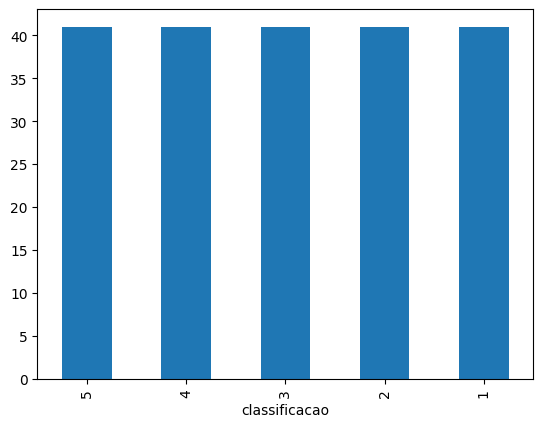

In [391]:
produtos_balanceado['classificacao'].value_counts().plot.bar()
print(produtos_balanceado.classificacao.value_counts())
print(len(produtos_balanceado))

### 4. Normalização

Alguns algoritmos de classificação, como K-Nearest Neighbors (KNN), são sensíveis à escala das variáveis de entrada. Se uma variável é medida em uma escala muito maior do que outra, ela pode dominar a função de decisão do modelo, levando a resultados imprecisos.

In [432]:
X = indicadores_produtos.drop(columns=['produto_id', 'classificacao'], axis = 1)
y = indicadores_produtos['classificacao']

In [433]:
norm = StandardScaler()

X_normalizado = norm.fit_transform(X)
X_normalizado

array([[-1.79227907, -2.07957271, -1.24638754],
       [-1.75995311, -1.76345432, -1.2110123 ],
       [-1.72300916, -1.826678  , -1.18742881],
       [-1.71839116, -1.70023064, -1.16384532],
       [-1.67682922, -1.57378328, -1.2110123 ],
       [-1.6075593 , -1.32088856, -1.25817928],
       [-1.55214337, -1.25766488, -0.96338564],
       [-1.53828939, -1.38411224, -1.15205357],
       [-1.5336714 , -1.5105596 , -1.14026182],
       [-1.50134544, -1.00477017, -0.95159389],
       [-1.43669352, -1.13121752, -1.09309484],
       [-1.41360355, -1.1944412 , -1.0577196 ],
       [-1.39051358, -1.00477017, -1.15205357],
       [-1.33971564, -0.94154649, -0.98696913],
       [-1.30738968, -0.87832281, -0.99876087],
       [-1.2935357 , -1.00477017, -0.69217548],
       [-1.27968171, -1.44733592, -0.96338564],
       [-1.21964779, -0.68865177, -0.9280104 ],
       [-1.2104118 , -0.75187545, -0.98696913],
       [-1.13652389, -1.25766488, -0.88084342],
       [-1.12266991, -0.62542809, -0.857

Tenho que explicar pq esta dividindo 30 teste e 70 treino. Explicar o motivo se escolher cada modelo. e Explicar toda linha de racioncínio.


### 5. Dividindo Amostra

In [434]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_normalizado, y, test_size=0.3)

Foi utilizado a regra 70/30, dividimos nossa amostra em base de treino com 70% dos dados e a base de teste com 30%. Pelo tamanho moderado da amostra, usar a regra 70/30 já é o suficiente para treinar o modelo de forma eficiente.

In [435]:
y_treino.value_counts()

classificacao
1    28
4    22
3    18
5    12
2    11
Name: count, dtype: int64

In [436]:
y_teste.value_counts()

classificacao
1    13
4    10
3     9
2     5
5     2
Name: count, dtype: int64

### 6. Aplicação dos Modelos

Para esse problema, escolhi trabalhar com os modelos mais simples KNN e Árvore de Decisão, pois a amostra não apresenta complexidade. Além disso, como a base foi balanceada, a avaliação dos modelos foi feita apenas com Acurácia e Validação Cruzada.

##### KNN

In [437]:
knn = KNeighborsClassifier(metric='euclidean')
knn.fit(X_treino, y_treino)

KNeighborsClassifier(metric='euclidean')

In [438]:
predito_knn = knn.predict(X_teste)
predito_knn

array([2, 4, 3, 1, 5, 1, 1, 3, 4, 1, 2, 1, 1, 1, 3, 1, 1, 1, 3, 4, 2, 4,
       4, 3, 4, 1, 3, 1, 2, 5, 1, 5, 4, 1, 4, 3, 3, 1, 4])

In [439]:
accuracy = accuracy_score(y_teste, predito_knn)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.49%


In [440]:
scores_dt = cross_val_score(knn, X_treino, y_treino, scoring='accuracy', cv=5)
print("Accuracy: %.2f%%" % (scores_dt.mean() * 100.0))

Accuracy: 87.89%


##### Árvore de Decisão

In [441]:
class_tree = DecisionTreeClassifier()
class_tree.fit(X_treino, y_treino)

DecisionTreeClassifier()

In [442]:
y_pred = class_tree.predict(X_teste)
y_pred

array([3, 4, 2, 1, 5, 1, 1, 4, 4, 1, 2, 1, 1, 1, 3, 2, 1, 1, 3, 4, 2, 4,
       4, 3, 4, 2, 3, 1, 3, 4, 1, 5, 3, 1, 4, 3, 3, 1, 4])

In [443]:
accuracy = accuracy_score(y_teste, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [444]:
scores_dt = cross_val_score(tree, X_treino, y_treino, scoring='accuracy', cv=5)
print("Accuracy: %.2f%%" % (scores_dt.mean() * 100.0))

Accuracy: 97.78%


De acordo com o resultado dos modelos, o algoritmo de Árvore de Decisão trouxe um resultado superior ao algoritmo de KNN. Portanto, ele foi o escolhido para melhor classificar os produtos da plataforma. Os modelos foram avaliados com e sem balanceamente e normalização dos dados. Pelos resultados, o balanceamente Oversampling e a normalização contribuíram para o aumento do desempenho do modelo.

Para concluir, vimos que grande parte dos produtos cadastrados estão apresentando compartamento ruim dentro da plataforma, sendo necessário criar uma ação de conscientização dos donos desses produtos e uma punição para o produtos que permancerem na mesma situação após um certo comportamento. Não só punir, mas a ação de premiar os melhores produtos também contribui para a permanência dos baixos indicadores.

### 7. Exportando o Modelo

In [445]:
# Exportando o modelo
import joblib

# Função
joblib.dump( class_tree, 'class_tree.pkl')

['class_tree.pkl']

In [446]:
# Testando o modelo treinado
Funcao_Modelo_Carregado = joblib.load('class_tree.pkl')

In [451]:
# Criando DataFrame
X_teste = pd.DataFrame(X_teste, columns = ['tx_estorno','reclamacoes','tx_chargeback'])

# Testando
Funcao_Modelo_Carregado.predict(X_teste.head(1).values)

array([3])